# Argo Sample Rate

This notebook will investigate the sample rate of argo floats and how to account for this while loading boxes, interpolating to a standard pressure grid, and performing analysis. This is important to resolve because some (many?) profiles seem to have sampling rates of >100m, which would greatly interfere with the accuracy of filtering analysis, particularly at small scales. See this issue for more specific thoughts on how to address this: https://github.com/ocean-transport/argo-intern/issues/12#issuecomment-1655683014

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import MLD_funcs as mf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
reload(mf)

<module 'MLD_funcs' from '/home/amf2288/argo-intern/MLD_funcs.py'>

In [68]:
import processing_funcs as prf
reload(prf)

<module 'processing_funcs' from '/home/amf2288/argo-intern/processing_funcs.py'>

In [79]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader=ArgoDataFetcher(src='gdac',ftp="/swot/SUM05/dbalwada/Argo_sync",parallel=True,progress=True)

ds = argo_loader.region([-10,0,-40,-30,0,2000])
print('loading points complete')
ds = ds.to_xarray()
print('to xarray complete')
ds = ds.argo.point2profile()
print('point to profile complete')

FtpPathError: This path is not GDAC compliant (no `dac` folder with legitimate sub-folder):
/swot/SUM05/dbalwada/Argo_sync

In [4]:
depth_min, depth_max = 0, 2000
rate = 4

median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
ind_rate=median_dp.where(median_dp<rate,drop=True).N_PROF
ds_sel=ds.sel(N_PROF=ind_rate)

ds_rate = ds_sel.PRES.diff('N_LEVELS').sortby('N_PROF')

In [5]:
#does diff reduce by one, when adding sample_rate as variable does it fill last point with nan

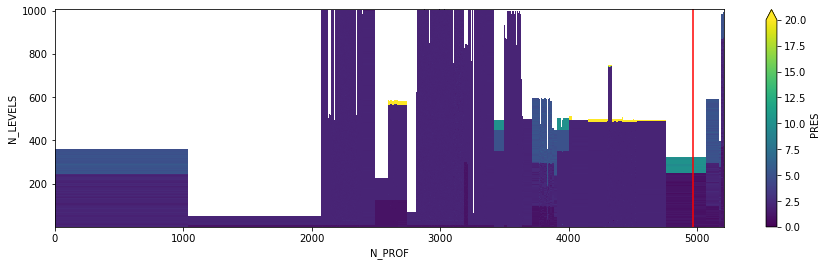

In [6]:
plt.figure(figsize=(15,4))
ds_rate.plot(x='N_PROF',y='N_LEVELS',vmin=0,vmax=20)
plt.axvline(4970,0,1000,color='r')#,linewidth=30)

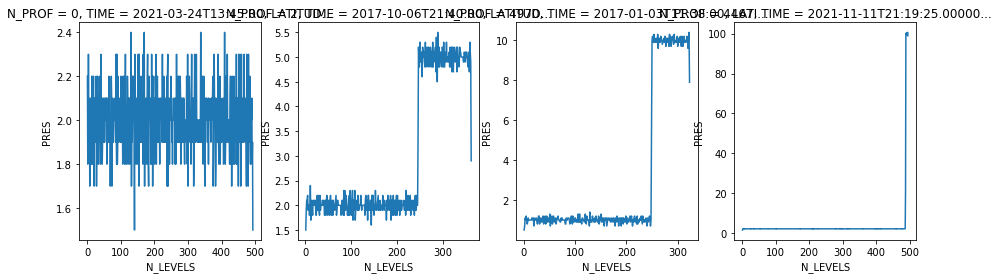

In [7]:
plt.figure(figsize=(15,4))

plt.subplot(1,4,1)
ds_rate.isel(N_PROF=0).plot()
plt.subplot(1,4,2)
ds_rate.isel(N_PROF=1).plot()
plt.subplot(1,4,3)
ds_rate.isel(N_PROF=1475).plot()
plt.subplot(1,4,4)
ds_rate.isel(N_PROF=1400).plot()

In [8]:
ds['sample_rate'] = ds_rate
ds_interp = ff.get_ds_interp(ds,0,2000,4)

AttributeError: module 'filt_funcs' has no attribute 'get_ds_interp'

In [ ]:
plt.figure(figsize=(15,4))
ds_interp.sample_rate.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED',vmin=0,vmax=50)

In [ ]:
#try process with one profile, follow through all steps, check intuition

In [ ]:
#for filtering: only take the part of the profile that has a sample rate >5m

In [ ]:
plt.figure(figsize=(15,4))
ds_interp.PSAL.plot(x='N_PROF_NEW',y='PRES_INTERPOLATED')
plt.gca().invert_yaxis()

In [ ]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
ds_interp.sample_rate.isel(N_PROF=0).plot()
plt.subplot(1,3,2)
ds_interp.sample_rate.isel(N_PROF=260).plot()
plt.subplot(1,3,3)
ds_interp.sample_rate.isel(N_PROF=785).plot()

## Write new get_ds_interp function

In [32]:
## OLD get_ds_interp function

def old_ds_interp(ds,depth_min,depth_max,sample_rate):
    
    '''Takes an Argo xarray with sampled pressure and:
    1) only selects profiles that sample at a rate equal to or greater than sample_rate
    2) interpolates the pressure to a 2m grid.
    3) returns an xarray with all profiles that meet the sample rate interpolated at 2m, with a new dimension PRES_INTERPOLATED
    
    ds: xarray dataset with dimensions PRES, N_LEVELS, N_PROF; pressure PRES
    depth_min: shallowest depth selected[m]
    depth_max: deepest depth selected [m]
    sample_rate: minimum sample rate [m]'''
    
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_rate,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    
    number=np.arange(0,len(ds_interp.N_PROF))
    ds_interp.coords['N_PROF_NEW']=xr.DataArray(number,dims=ds_interp.N_PROF.dims)
    return ds_sel

In [33]:
old_interp = old_ds_interp(ds,0,2001,4)
old_interp

<xarray.Dataset>
Dimensions:                (N_PROF: 1493, N_LEVELS: 1006)
Coordinates:
  * N_PROF                 (N_PROF) int64 3505 3506 3507 3493 ... 2231 4525 3315
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 ... 1002 1003 1004 1005
    TIME                   (N_PROF) datetime64[ns] 2011-11-15T15:38:35 ... 20...
    LATITUDE               (N_PROF) float64 -30.32 -30.98 -31.2 ... -34.97 -30.5
    LONGITUDE              (N_PROF) float64 -3.401 -3.714 ... -0.077 -8.804
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 1 1 1 1 1 1 1 1 ... 4 4 14 2 4 5 14 4
    CYCLE_NUMBER           (N_PROF) int32 4 5 6 6 7 7 8 ... 14 12 208 227 14 71
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'R' 'A' 'A' 'R'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 3900833 3900833 ... 5906490 1902278
    POSITION_QC            (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_PROF, N_LEVELS) float32 35.83 35.83 ... nan nan
    PSAL_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_PROF, N_LEVELS) float32 17.63 17.63 ... nan nan
    TEMP_QC                (N_PROF, N_LEVELS) int32 1 1 1 1 ... 1 1 99999 99999
    TIME_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/08/03
    Fetched_constraints:  [x=-10.00/0.00; y=-40.00/-30.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/coriolis/7900501...
    history:              Variables filtered according to DATA_MODE; Variable...

In [ ]:
def get_ds_interp(ds,depth_min,depth_max,interp_step):
    '''
    '''
    
    dp = ds.PRES.diff('N_LEVELS').sortby('N_PROF')
    ds['sample_rate'] = dp
    ds_interp = ds.argo.interp_std_levels(np.arange(depth_min,depth_max,interp_step))
    
    return ds_interp

In [75]:
## NEW get_ds_interp function

def new_ds_interp(ds,depth_min=0,depth_max=2001,interp_step=2):
    '''
    '''
    dp = ds.PRES.diff('N_LEVELS').sortby('N_PROF')
    ds['sample_rate'] = dp
    ds_interp = ds.argo.interp_std_levels(np.arange(depth_min,depth_max,interp_step))
    
    return ds_interp

In [78]:
ds

<xarray.Dataset>
Dimensions:                (N_PROF: 5348, N_LEVELS: 1006)
Coordinates:
  * N_PROF                 (N_PROF) int64 4 5 6 7 8 ... 5173 3098 2231 4525 3315
  * N_LEVELS               (N_LEVELS) int64 0 1 2 3 4 ... 1002 1003 1004 1005
    TIME                   (N_PROF) datetime64[ns] 2002-12-11T14:47:32 ... 20...
    LATITUDE               (N_PROF) float64 -34.73 -34.61 ... -34.97 -30.5
    LONGITUDE              (N_PROF) float64 -9.135 -9.183 ... -0.077 -8.804
    sample_rate            (N_PROF, N_LEVELS) float32 nan 10.0 10.0 ... nan nan
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 1 1 1 1 1 1 -1 -1 ... 4 14 2 4 5 14 4
    CYCLE_NUMBER           (N_PROF) int32 4 5 6 7 8 18 1 ... 14 12 208 227 14 71
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'R' 'A' 'A' 'R'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1900058 1900058 ... 5906490 1902278
    POSITION_QC            (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_PROF) int32 1 1 1 1 1 1 2 2 2 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_PROF, N_LEVELS) float32 35.33 35.33 ... nan nan
    PSAL_QC                (N_PROF) int32 1 1 1 1 1 1 2 2 2 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_PROF, N_LEVELS) float32 14.85 14.7 ... nan nan
    TEMP_QC                (N_PROF, N_LEVELS) int32 1 1 1 1 ... 1 1 99999 99999
    TIME_QC                (N_PROF) int32 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/08/03
    Fetched_constraints:  [x=-10.00/0.00; y=-40.00/-30.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/coriolis/7900501...
    history:              Variables filtered according to DATA_MODE; Variable...

In [77]:
new_interp = new_ds_interp(ds)

In [69]:
import processing_funcs as prf

box = prf.get_box([-10,0,-40,-30,0,2000],2)

loading points complete


100%|██████████| 194/194 [06:25<00:00,  1.99s/it]


to xarray complete
point to profile complete
interpolation complete
adding spice complete
adding MLD complete


In [74]:
box

<xarray.Dataset>
Dimensions:                (N_PROF: 2, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF                 (N_PROF) int64 353 1896
    TIME                   (N_PROF) datetime64[ns] 2010-02-15T13:38:42 2021-0...
    LATITUDE               (N_PROF) float64 -39.08 -33.01
    LONGITUDE              (N_PROF) float64 -0.706 -2.131
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 2 4 6 8 ... 1996 1998 2000
    MLD                    (N_PROF) int64 70 60
    month                  (N_PROF) int64 2 4
    month_frac             (N_PROF) float64 2.556 4.934
    year                   (N_PROF) int64 2010 2021
    year_frac              (N_PROF) float64 2.01e+03 2.021e+03
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_PROF) int32 1 267
    CT                     (N_PROF, PRES_INTERPOLATED) float64 14.41 ... 2.597
    CYCLE_NUMBER           (N_PROF) int32 33 267
    DATA_MODE              (N_PROF) <U1 'D' 'A'
    DIRECTION              (N_PROF) <U1 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1900981 3901116
    ...                     ...
    PSAL                   (N_PROF, PRES_INTERPOLATED) float32 34.6 ... 34.79
    SA                     (N_PROF, PRES_INTERPOLATED) float64 34.77 ... 34.96
    SIG0                   (N_PROF, PRES_INTERPOLATED) float64 25.8 ... 27.76
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 14.42 ... 2.747
    sample_rate            (N_PROF, PRES_INTERPOLATED) float32 5.7 5.7 ... 1.723
    SPICE                  (N_PROF, PRES_INTERPOLATED) float64 1.857 ... 0.06422
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/08/03
    Fetched_constraints:  [x=-10.00/0.00; y=-40.00/-30.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/coriolis/7900501...
    history:              Variables filtered according to DATA_MODE; Variable...

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

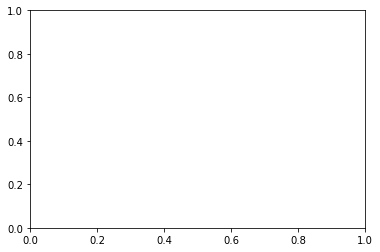

In [57]:
box.sample_rate.plot(x='N_PROF',y='PRES_INTERPOLATED')